## Import libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
from skimage import img_as_ubyte
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Preprocessing gray scale and rgb images
We aimed to standardize our images through a series of preprocessing steps. The process involved reading color images from a directory where the background had been removed:


<li> We read the input color image from directory with background-removed to resize gray scale images.</li>
<li>Normalize pixel values of the resized images by dividing by 255 (range: 0 - 255).</li>
<li>Employ DBSCAN to identify and remove duplicate images.</li>
<li>Display the resulting shape of the numpy array (npy) and image counts after applying the preprocessing steps.</li>
<li>Split the grayscale and RGB datasets into training, testing, and validation sets with an 80/20 ratio.</li>

## Preprocessing for gray scale images

In [2]:
def preprocessing1_convert_grayscale(img):
    if img is not None and img.size > 0:
        processed_img = img  
        if len(img.shape) == 3 and img.shape[2] == 3:  # Check if the image has 3 channels
            processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)  # Convert Color to Grayscale
        else:
            processed_img = processed_img
        return processed_img
    return None

In [3]:
def preprocessing2_remove_dups_normalize_gray(images_file_path, labels_file_path):
    # Load npy files
    X = np.load(images_file_path)
    labels = np.load(labels_file_path) if labels_file_path is not None else None

    # Remove duplicates and normalize pixel values to 0 - 255
    image_set = [preprocessing1_convert_grayscale(img) for img in X]
    print(f'len(image_set) = {len(image_set)}')
    scaled_image_set = [np.ravel((image / 255)) for image in image_set]  # Pixel normalization: Scaled because DBSCAN calculates distance

    dbs_cluster = DBSCAN(eps=.5, min_samples=2).fit(scaled_image_set)  # Remove duplicates
    print(f'dbs_cluster = {dbs_cluster.labels_}, {dbs_cluster}')

    clean_image_index = []
    deduped_images = []
    deduped_labels = []

    # Create a dictionary to store the first occurrence of each label
    label_first_occurrence = {}

    for idx, label in enumerate(dbs_cluster.labels_):
        if label == -1:
            clean_image_index.append(idx)
            deduped_labels.append(labels[idx]) if labels is not None else None
        else:  # Duplicates
            if label not in label_first_occurrence:
                label_first_occurrence[label] = idx
            clean_image_index.append(label_first_occurrence[label])
            deduped_labels.append(labels[label_first_occurrence[label]]) if labels is not None else None

    clean_image_index = list(dict.fromkeys(clean_image_index))

    for i in clean_image_index:
        deduped_images.append(scaled_image_set[i])

    print(f'number of duplicate images = {len(dbs_cluster.labels_) - len(clean_image_index)}')
    print(f'number of de-duplicated images = {len(clean_image_index)}')

    print("Length of labels:", len(labels))
    print("Length of clean_image_index:", len(clean_image_index))
    
    return [img_as_ubyte(im) for im in deduped_images], deduped_labels, clean_image_index


In [4]:
# Data load
images_file_path = "npy/trashbox_224x224.npy"
labels_file_path = "npy/labels.npy"
result_images, result_labels, clean_image_index = preprocessing2_remove_dups_normalize_gray(images_file_path, labels_file_path)

len(image_set) = 23685
dbs_cluster = [   0    1    2 ... 8770 8771 8772], DBSCAN(min_samples=2)
number of duplicate images = 8966
number of de-duplicated images = 14719
Length of labels: 23685
Length of clean_image_index: 14719


In [5]:
def filter_labels_by_indices(labels, indices):
    if labels is None or len(labels) == 0 or not all(0 <= i < len(labels) for i in indices):
        return None
    return [labels[i] for i in indices]

# Extract labels after duplicate images removed
clean_image_labels = filter_labels_by_indices(result_labels, clean_image_index)

# Check if clean_image_labels is not None before printing its length
if clean_image_labels is not None:
    print("Number of clean image labels:", len(clean_image_labels))
else:
    print("Clean image labels are not available.")

Number of clean image labels: 14719


In [6]:
# Change list of images to NumPy array
result_images_array = np.array(result_images)

# Convert result_labels to a NumPy array
result_labels_array = np.array(clean_image_labels)

# Reshape to (number_of_images, 224, 224)
result_images_2d = result_images_array.reshape(-1, 224, 224)

In [7]:
print("Shape of result_images:", result_images_2d.shape)
print("Shape of label:", result_labels_array.shape)

Shape of result_images: (14719, 224, 224)
Shape of label: (14719,)


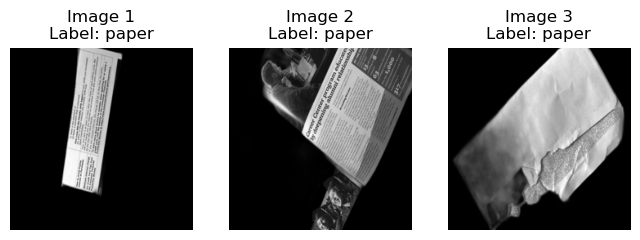

In [8]:
# Display the first 5 images with labels
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

# Display the first 5 images with labels
for i in range(3):
    axs[i].imshow(result_images_2d[i], cmap='gray')  # Use cmap='gray' for grayscale images
    axs[i].set_title(f'Image {i + 1}\nLabel: {result_labels[i]}')
    axs[i].axis('off')  # Turn off axis labels

plt.show()

## Split gray scale images into train/test/val set (80/10/10) and save as .npy

In [9]:
# Save result_images_2d as 'gray_224x224.npy' file
np.save('gray_224x224.npy', result_images_2d)

# Save result_labels_array as 'gray_label.npy' file
np.save('gray_label.npy', result_labels_array)

In [10]:
# Split the data into train, test, and validation sets (80/10/10 split)
X_train, X_temp, labels_train, labels_temp = train_test_split(result_images_2d, result_labels_array, test_size=0.2, random_state=42, stratify=result_labels_array)
X_val, X_test, labels_val, labels_test = train_test_split(X_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

In [11]:
# Specify the output file paths for training set
output_images_train_file_path = "gray_224x224_train.npy"
output_labels_train_file_path = "gray_labels_train.npy"
np.save(output_images_train_file_path, X_train)
np.save(output_labels_train_file_path, labels_train)

In [12]:
# Save validation set
output_images_val_file_path = "gray_224x224_val.npy"
output_labels_val_file_path = "gray_labels_val.npy"
np.save(output_images_val_file_path, X_val)
np.save(output_labels_val_file_path, labels_val)

In [13]:
# Save test set
output_images_test_file_path = "gray_224x224_test.npy"
output_labels_test_file_path = "gray_labels_test.npy"
np.save(output_images_test_file_path, X_test)
np.save(output_labels_test_file_path, labels_test)

## Preprocessing for RGB images

In [14]:
def preprocessing_remove_dups_normalize_rgb(images_file_path, labels_file_path):
    # Load npy files
    X = np.load(images_file_path)
    labels = np.load(labels_file_path) if labels_file_path is not None else None

    # Remove duplicates and normalize pixel values to 0 - 255
    image_set = [img_as_ubyte(img) for img in X]
    print(f'len(image_set) = {len(image_set)}')
    scaled_image_set = [np.ravel((image / 255)) for image in image_set]  # Pixel normalization: Scaled because DBSCAN calculates distance

    dbs_cluster = DBSCAN(eps=.5, min_samples=2).fit(scaled_image_set)  # Remove duplicates
    print(f'dbs_cluster = {dbs_cluster.labels_}, {dbs_cluster}')

    clean_image_index = []
    deduped_images = []
    deduped_labels = []

    # Create a dictionary to store the first occurrence of each label
    label_first_occurrence = {}

    for idx, label in enumerate(dbs_cluster.labels_):
        if label == -1:
            clean_image_index.append(idx)
            deduped_labels.append(labels[idx]) if labels is not None else None
        else:  # Duplicates
            if label not in label_first_occurrence:
                label_first_occurrence[label] = idx
            clean_image_index.append(label_first_occurrence[label])
            deduped_labels.append(labels[label_first_occurrence[label]]) if labels is not None else None

    clean_image_index = list(dict.fromkeys(clean_image_index))

    for i in clean_image_index:
        deduped_images.append(scaled_image_set[i])

    print(f'number of duplicate images = {len(dbs_cluster.labels_) - len(clean_image_index)}')
    print(f'number of de-duplicated images = {len(clean_image_index)}')

    print("Length of labels:", len(labels))
    print("Length of clean_image_index:", len(clean_image_index))
    
    return deduped_images, deduped_labels, clean_image_index

In [15]:
# Data Load
images_file_path = "npy/trashbox_224x224.npy"
labels_file_path = "npy/labels.npy"
result_images, result_labels, clean_image_index = preprocessing_remove_dups_normalize_rgb(images_file_path, labels_file_path)

len(image_set) = 23685
dbs_cluster = [   0    1    2 ... 8783 8784 8785], DBSCAN(min_samples=2)
number of duplicate images = 8949
number of de-duplicated images = 14736
Length of labels: 23685
Length of clean_image_index: 14736


In [16]:
def filter_labels_by_indices(labels, indices):
    if labels is None or len(labels) == 0 or not all(0 <= i < len(labels) for i in indices):
        return None
    return [labels[i] for i in indices]

# Extract labels after duplicate images removed
clean_image_labels = filter_labels_by_indices(result_labels, clean_image_index)

# Check if clean_image_labels is not None before printing its length
if clean_image_labels is not None:
    print("Number of clean image labels:", len(clean_image_labels))
else:
    print("Clean image labels are not available.")

Number of clean image labels: 14736


In [17]:
# Change list of images to NumPy array
result_images_array = np.array(result_images)

# Convert result_labels to a NumPy array
result_labels_array = np.array(clean_image_labels)

# Reshape to (number_of_images, 224, 224, 3)
result_images_3d = result_images_array.reshape(-1, 224, 224, 3)

In [18]:
print("Shape of result_images:", result_images_3d.shape)
print("Shape of label:", result_labels_array.shape)

Shape of result_images: (14736, 224, 224, 3)
Shape of label: (14736,)


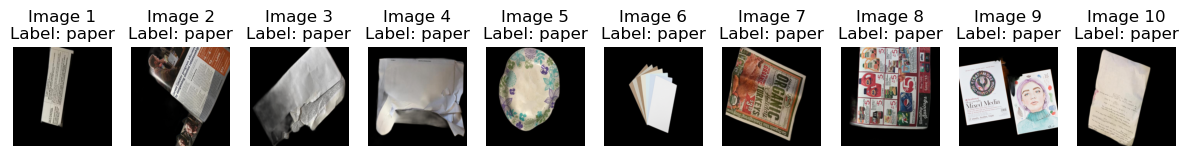

In [19]:
# Display the first 5 images with labels
fig, axs = plt.subplots(1, 10, figsize=(15, 3))

# Display the first 5 images with labels
for i in range(10):
    axs[i].imshow(result_images_3d[i])  # Use cmap='gray' for grayscale images
    axs[i].set_title(f'Image {i + 1}\nLabel: {result_labels[i]}')
    axs[i].axis('off')  # Turn off axis labels

plt.show()

## Split RGB images into train/test/val set (80/10/10) and save as .npy

In [20]:
# Save result_images_3d as 'rgb_224x224.npy' file
np.save('rgb_224x224.npy', result_images_3d)

# Save result_labels_array as 'rgb_label.npy' file
np.save('rgb_label.npy', result_labels_array)

In [21]:
# Split the data into train, test, and validation sets (80/10/10 split)
X_train, X_temp, labels_train, labels_temp = train_test_split(result_images_3d, result_labels_array, test_size=0.2, random_state=42, stratify=result_labels_array)
X_val, X_test, labels_val, labels_test = train_test_split(X_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

In [22]:
# Specify the output file paths for training set
output_images_train_file_path = "rgb_224x224_train.npy"
output_labels_train_file_path = "rgb_labels_train.npy"
np.save(output_images_train_file_path, X_train)
np.save(output_labels_train_file_path, labels_train)

In [23]:
# Save validation set
output_images_val_file_path = "rgb_224x224_val.npy"
output_labels_val_file_path = "rgb_labels_val.npy"
np.save(output_images_val_file_path, X_val)
np.save(output_labels_val_file_path, labels_val)

In [24]:
# Save test set
output_images_test_file_path = "rgb_224x224_test.npy"
output_labels_test_file_path = "rgb_labels_test.npy"
np.save(output_images_test_file_path, X_test)
np.save(output_labels_test_file_path, labels_test)

## Label counts after data split
Provide counts of labels in the training, testing, and validation sets to ensure a comprehensive representation of all labels in each set.

In [25]:
# Training set
unique_labels_train, counts_train = np.unique(labels_train, return_counts=True)
label_count_train = dict(zip(unique_labels_train, counts_train))

# Validation set
unique_labels_val, counts_val = np.unique(labels_val, return_counts=True)
label_count_val = dict(zip(unique_labels_val, counts_val))

# Test set
unique_labels_test, counts_test = np.unique(labels_test, return_counts=True)
label_count_test = dict(zip(unique_labels_test, counts_test))

# Create DataFrames
df_train = pd.DataFrame(list(label_count_train.items()), columns=['Label', 'Count']).sort_values(by='Label')
df_val = pd.DataFrame(list(label_count_val.items()), columns=['Label', 'Count']).sort_values(by='Label')
df_test = pd.DataFrame(list(label_count_test.items()), columns=['Label', 'Count']).sort_values(by='Label')

# Display the tables
print("Label counts in training set:")
print(df_train)

print("\nLabel counts in validation set:")
print(df_val)

print("\nLabel counts in test set:")
print(df_test)


Label counts in training set:
                 Label  Count
0              battery   1255
1        beverage cans    565
2            cardboard    907
3       cigarette butt    298
4   construction scrap    239
5    electrical cables    298
6     electronic chips    210
7                glass   1452
8               gloves    255
9              laptops    130
10               masks    294
11           medicines    288
12    metal containers    325
13          news paper     94
14               paper    451
15          paper_cups    373
16        plastic bags    291
17     plastic bottles    346
18  plastic containers    368
19        plastic_cups    314
20    small appliances    553
21         smartphones    165
22          spray cans    288
23             syringe    212
24           tetra pak    456
25               trash   1361

Label counts in validation set:
                 Label  Count
0              battery    157
1        beverage cans     71
2            cardboard    114
3      